In [1]:
!pip install scikit-learn==1.2.2
!pip install nltk==3.8.1
!pip install numpy==1.23.5
!pip install pandas==1.5.3
!pip install matplotlib==3.7.1
!pip install sastrawi==1.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import pustaka yang diperlukan

In [3]:
import nltk
nltk.download("stopwords")
nltk.download("punkt")

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import string
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Import Data

In [4]:
df = pd.read_csv('/content/drive/MyDrive/proyek-sms_spam/dataset/dataset_spam.csv')
df.head()

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,1
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,1
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",1
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",1
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,1


In [5]:
#Mengecek data yang bolong
df.isna().sum()

Teks     0
label    0
dtype: int64

In [6]:
# Cek Duplicate
df.duplicated().sum()

0

In [7]:
df.shape

(1623, 2)

In [8]:
# Menghapus baris dengan data duplikat dan mempertahankan baris pertama
df.drop_duplicates(keep='first', inplace=True)

In [9]:
# Cek Duplicate
df.duplicated().sum()

0

In [10]:
df.shape

(1623, 2)

# EDA

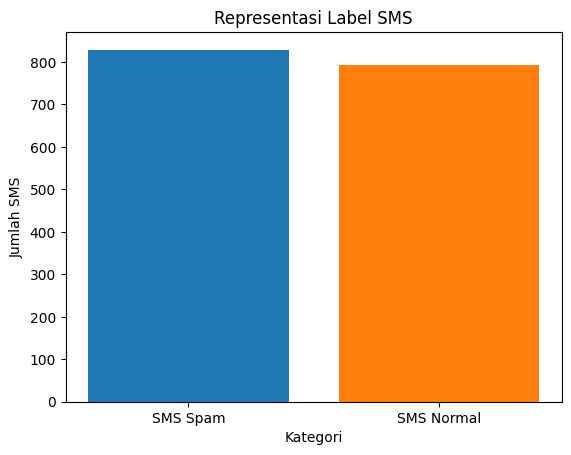

SMS Spam      829
SMS Normal    794
Name: label, dtype: int64


In [11]:
import matplotlib.pyplot as plt

# Calculate value counts
value_counts = df['label'].value_counts()

# Add label descriptions
label_descriptions = {1: 'SMS Spam', 0: 'SMS Normal'}
value_counts.index = value_counts.index.map(label_descriptions)

# Separate 'SMS Spam' and 'SMS Normal' counts
sms_spam_count = value_counts['SMS Spam']
sms_normal_count = value_counts['SMS Normal']

# Create the bar plot
fig, ax = plt.subplots()
ax.bar('SMS Spam', sms_spam_count)
ax.bar('SMS Normal', sms_normal_count)

ax.set_xlabel('Kategori')
ax.set_ylabel('Jumlah SMS')
ax.set_title('Representasi Label SMS')

plt.show()

print(value_counts)


In [12]:
# Fungsi untuk mengekstrak fitur tambahan
def ekstrak_fitur(text):
    num_kata = len(word_tokenize(text))
    num_kalimat = len(sent_tokenize(text))
    num_karakter = len(text)
    return num_kata, num_kalimat, num_karakter

df['jumlah_kata'], df['jumlah_kalimat'], df['jumlah_karakter'] = zip(*df['Teks'].apply(ekstrak_fitur))
df.head()

,Teks,label,jumlah_kata,jumlah_kalimat,jumlah_karakter
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,1,32,2,153
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,1,34,4,152
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",1,29,2,152
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",1,29,2,153
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,1,25,3,113


In [13]:
# Menampilkan statistik deskriptif
df[['jumlah_karakter', 'jumlah_kata', 'jumlah_kalimat']].describe()

,jumlah_karakter,jumlah_kata,jumlah_kalimat
count,1623.000000,1623.000000,1623.000000
mean,109.706716,20.120148,1.841035
std,57.330431,10.415995,1.152114
min,9.000000,1.000000,1.000000
25%,59.000000,11.000000,1.000000
50%,119.000000,20.000000,1.000000
75%,153.000000,27.000000,2.000000
max,434.000000,83.000000,11.000000


In [14]:
# Menampilkan statistik deskriptif untuk target Sms Normal
df[df['label'] == 0][['jumlah_karakter', 'jumlah_kata', 'jumlah_kalimat']].describe()

,jumlah_karakter,jumlah_kata,jumlah_kalimat
count,794.000000,794.000000,794.000000
mean,72.871537,14.011335,1.448363
std,48.919045,8.934602,0.830065
min,9.000000,1.000000,1.000000
25%,39.250000,8.000000,1.000000
50%,59.000000,12.000000,1.000000
75%,92.000000,18.000000,2.000000
max,434.000000,73.000000,11.000000


In [15]:
# Menampilkan statistik deskriptif untuk target Sms Spam
df[df['label'] == 1][['jumlah_karakter', 'jumlah_kata', 'jumlah_kalimat']].describe()

,jumlah_karakter,jumlah_kata,jumlah_kalimat
count,829.000000,829.000000,829.000000
mean,144.986731,25.971049,2.217129
std,39.992222,8.125176,1.284860
min,34.000000,6.000000,1.000000
25%,128.000000,21.000000,1.000000
50%,148.000000,25.000000,2.000000
75%,158.000000,30.000000,3.000000
max,431.000000,83.000000,9.000000


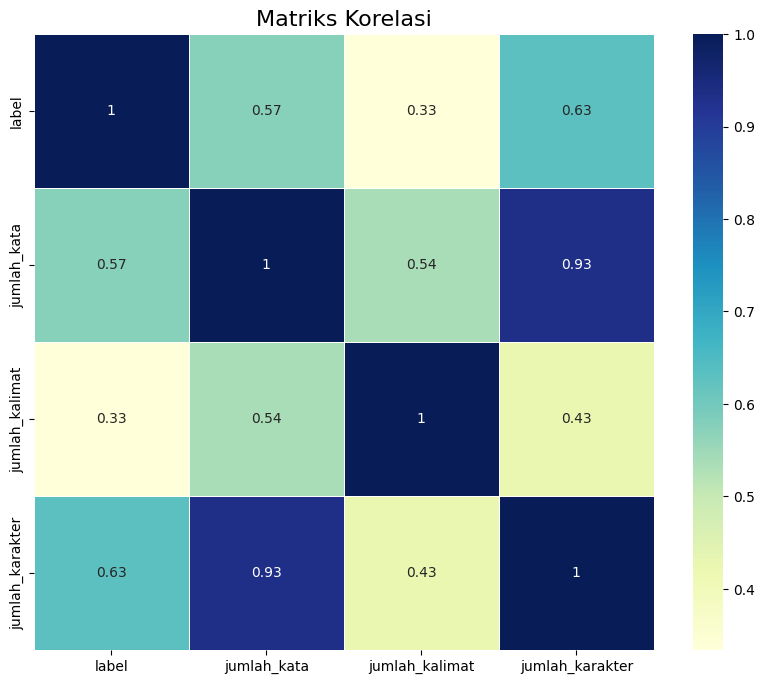

In [16]:
import seaborn as sns
import numpy as np

# Mengambil kolom numerik dari DataFrame
numeric_cols = df.select_dtypes(include=[np.number])

# Membuat matriks korelasi
corr_matrix = numeric_cols.corr()

# Menampilkan matriks korelasi dengan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', linewidths=0.5)
plt.title('Matriks Korelasi', fontsize=16)
plt.show()


In [17]:
from string import punctuation

punctuation_list = list(punctuation)
print("Daftar Punctuation:")
print("=" * 20)

symbols_per_line = 5  # Jumlah simbol per baris

for i in range(0, len(punctuation_list), symbols_per_line):
    symbols = punctuation_list[i:i + symbols_per_line]
    formatted_symbols = ", ".join(symbols)
    print(formatted_symbols)

Daftar Punctuation:
!, ", #, $, %
&, ', (, ), *
+, ,, -, ., /
:, ;, <, =, >
?, @, [, \, ]
^, _, `, {, |
}, ~


In [18]:
stopwords.words('indonesian')

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'amat',
 'amatlah',
 'anda',
 'andalah',
 'antar',
 'antara',
 'antaranya',
 'apa',
 'apaan',
 'apabila',
 'apakah',
 'apalagi',
 'apatah',
 'artinya',
 'asal',
 'asalkan',
 'atas',
 'atau',
 'ataukah',
 'ataupun',
 'awal',
 'awalnya',
 'bagai',
 'bagaikan',
 'bagaimana',
 'bagaimanakah',
 'bagaimanapun',
 'bagi',
 'bagian',
 'bahkan',
 'bahwa',
 'bahwasanya',
 'baik',
 'bakal',
 'bakalan',
 'balik',
 'banyak',
 'bapak',
 'baru',
 'bawah',
 'beberapa',
 'begini',
 'beginian',
 'beginikah',
 'beginilah',
 'begitu',
 'begitukah',
 'begitulah',
 'begitupun',
 'bekerja',
 'belakang',
 'belakangan',
 'belum',
 'belumlah',
 'benar',
 'benarkah',
 'benarlah',
 'berada',
 'berakhir',
 'berakhirlah',
 'berakhirnya',
 'berapa',
 'berapakah',
 'berapalah',
 'berapapun',
 'berarti',
 'berawal',
 'berbagai',
 'berdatangan',
 'beri',
 'berikan',
 'berikut'

# Data Preprocessor

In [19]:
def case_folding(text):
    # Mengubah teks menjadi huruf kecil (case folding) dan menghapus karakter khusus, angka, dan tanda baca
    preprocessed_text = ''.join(char.lower() for char in text if char.isalnum() or char.isspace())
    return preprocessed_text
input_text = "Anda Telah Resmi meraih Hadiah Ke 2 Mendapat Cek Tunai Rp.37 juta,Kode ID PIN pemenang Anda (02844254) Untuk Info Lebih Jelas Kunjungi www. galerypemenang2018.cf"

# Menggunakan case folding
preprocessed_text = case_folding(input_text)

print(preprocessed_text)


anda telah resmi meraih hadiah ke 2 mendapat cek tunai rp37 jutakode id pin pemenang anda 02844254 untuk info lebih jelas kunjungi www galerypemenang2018cf


In [20]:
# Tokenisasi Teks
input_text = "Anda Telah Resmi meraih Hadiah Ke 2 Mendapat Cek Tunai Rp.37 juta,Kode ID PIN pemenang Anda (02844254) Untuk Info Lebih Jelas Kunjungi www. galerypemenang2018.cf"
tokens = nltk.word_tokenize(input_text)
print(tokens)

['Anda', 'Telah', 'Resmi', 'meraih', 'Hadiah', 'Ke', '2', 'Mendapat', 'Cek', 'Tunai', 'Rp.37', 'juta', ',', 'Kode', 'ID', 'PIN', 'pemenang', 'Anda', '(', '02844254', ')', 'Untuk', 'Info', 'Lebih', 'Jelas', 'Kunjungi', 'www', '.', 'galerypemenang2018.cf']


In [21]:
from nltk.corpus import stopwords
import string

def remove_stopwords(text):
    # Menghapus stopwords (kata-kata umum) dalam bahasa Indonesia dan tanda baca
    tokens = [word for word in text.split() if word.lower() not in stopwords.words('indonesian') + list(string.punctuation)]
    return " ".join(tokens)

input_text = "Anda Telah Resmi meraih Hadiah Ke 2 Mendapat Cek Tunai Rp.37 juta,Kode ID PIN pemenang Anda (02844254) Untuk Info Lebih Jelas Kunjungi www. galerypemenang2018.cf"

# Menggunakan fungsi remove_stopwords
cleaned_text = remove_stopwords(input_text)
print(cleaned_text)


Resmi meraih Hadiah 2 Cek Tunai Rp.37 juta,Kode ID PIN pemenang (02844254) Info Kunjungi www. galerypemenang2018.cf


In [22]:
# Stemming (Menghilangkan Imbuhan)
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

input_word = "Anda Telah Resmi meraih Hadiah Ke 2 Mendapat Cek Tunai Rp.37 juta,Kode ID PIN pemenang Anda (02844254) Untuk Info Lebih Jelas Kunjungi www. galerypemenang2018.cf"
stemmed_word = stemmer.stem(input_word)
print(stemmed_word)

anda telah resmi raih hadiah ke 2 dapat cek tunai rp 37 juta kode id pin menang anda 02844254 untuk info lebih jelas kunjung www galerypemenang2018 cf


In [23]:
# Inisialisasi factory stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Fungsi untuk mengubah teks SMS
def transform_text(text):
    # 1. Mengubah teks menjadi huruf kecil (case folding)
    text = text.lower()

    # 2. Menghapus karakter khusus, angka, dan tanda baca
    text = ''.join(char for char in text if char.isalnum() or char.isspace())

    # 3. Tokenisasi teks
    tokens = nltk.word_tokenize(text)

    # 4. Menghapus stopwords (kata-kata umum) dalam bahasa Indonesia
    stopword = stopwords.words('indonesian')
    tokens = [word for word in tokens if word not in stopword]

    # 5. Stemming (menghilangkan imbuhan)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    # 6. Menggabungkan token-token yang sudah diproses menjadi teks kembali
    preprocessed_text = ' '.join(stemmed_tokens)

    return preprocessed_text

In [24]:
transform_text("Anda Telah Resmi meraih Hadiah Ke 2 Mendapat Cek Tunai Rp.37 juta,Kode ID PIN pemenang Anda (02844254) Untuk Info Lebih Jelas Kunjungi www. galerypemenang2018.cf")

'resmi raih hadiah 2 cek tunai rp37 jutakode id pin menang 02844254 info kunjung www galerypemenang2018cf'

In [25]:
df.head()

,Teks,label,jumlah_kata,jumlah_kalimat,jumlah_karakter
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,1,32,2,153
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,1,34,4,152
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",1,29,2,152
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",1,29,2,153
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,1,25,3,113


In [26]:
df['teks']=df['Teks'].apply(transform_text)
df.head()

,Teks,label,jumlah_kata,jumlah_kalimat,jumlah_karakter,teks
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,1,32,2,153,promo beli paket flash 1gb my telkomsel app dp...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,1,34,4,152,25 gb30 rp 35 ribu spesial pilih aktif 550905 ...
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",1,29,2,152,20160708 114711plg yth sisa kuota flash 478kb ...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",1,29,2,153,20160807 112947plg yth sisa kuota flash 7160kb...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,1,25,3,113,45gb30 rp 55 ribu spesial pilih aktif 550907 b...


In [27]:
for text in df['Teks'][:5]:
    print(text)
    print("\n" + "="*50 + "\n")

[PROMO] Beli paket Flash mulai 1GB di MY TELKOMSEL APP dpt EXTRA kuota 2GB 4G LTE dan EXTRA nelpon hingga 100mnt/1hr. Buruan, cek  di tsel.me/mytsel1 S&K


2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat Anda yang terpilih. Aktifkan sekarang juga di *550*905#. Promo sd 30 Nov 2015.Buruan aktifkan sekarang. S&K


2016-07-08 11:47:11.Plg Yth, sisa kuota Flash Anda 478KB. Download MyTelkomsel apps di http://tsel.me/tsel utk cek kuota&beli paket Flash atau hub *363#


2016-08-07 11:29:47.Plg Yth, sisa kuota Flash Anda 7160KB. Download MyTelkomsel apps di http://tsel.me/tsel utk cek kuota&beli paket Flash atau hub *363#


4.5GB/30 hari hanya Rp 55 Ribu Spesial buat anda yang terpilih. Aktifkan sekarang juga di *550*907# Buruan..! SKB




In [28]:
for text in df['teks'][:5]:
    print(text)
    print("\n" + "="*50 + "\n")

promo beli paket flash 1gb my telkomsel app dpt extra kuota 2gb 4g lte extra nelpon 100mnt1hr buru cek tselmemytsel1 sk


25 gb30 rp 35 ribu spesial pilih aktif 550905 promo sd 30 nov 2015buruan aktif sk


20160708 114711plg yth sisa kuota flash 478kb download mytelkomsel apps httptselmetsel utk cek kuotabeli paket flash hub 363


20160807 112947plg yth sisa kuota flash 7160kb download mytelkomsel apps httptselmetsel utk cek kuotabeli paket flash hub 363


45gb30 rp 55 ribu spesial pilih aktif 550907 buru skb




In [29]:
# Mengambil teks SMS spam yang telah di-transformasi
spam_text_transformed = df[df['label'] == 1]['teks']

# Menggabungkan semua teks SMS spam menjadi satu teks panjang
spam_corpus = ' '.join(spam_text_transformed)

# Membagi teks panjang menjadi kata-kata
spam_words = spam_corpus.split()

# Menghitung frekuensi kemunculan kata-kata
from collections import Counter
word_counts = Counter(spam_words)

# Membuat DataFrame dengan 50 kata paling umum
top_50_words = pd.DataFrame(word_counts.most_common(50), columns=['Kata', 'Frekuensi'])

# Menampilkan 50 kata paling umum
print(top_50_words)

         Kata  Frekuensi
0        info        166
1       paket        154
2         sms        140
3      hadiah        134
4        klik        133
5       pulsa        132
6       promo        129
7         cek        112
8         utk        106
9          no        106
10        pin        105
11      kuota         98
12       beli         95
13     menang         89
14         sd         88
15        isi         88
16        hub         85
17         rp         84
18     gratis         79
19      resmi         77
20          1         74
21    selamat         74
22      ketik         71
23      bonus         71
24         dr         64
25       laku         64
26      uinfo         62
27      pilih         61
28      kirim         61
29    langgan         61
30      ulang         61
31        dgn         59
32        tri         56
33      dapat         53
34      aktif         51
35       undi         46
36         sk         42
37      tukar         42
38  telkomsel         41


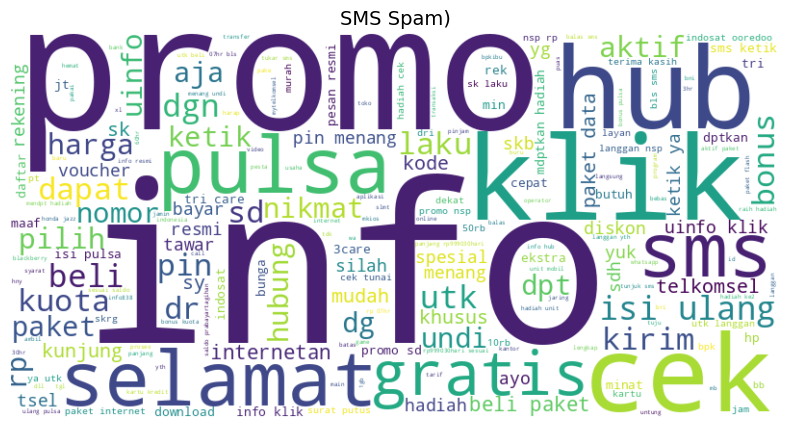

In [30]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Fungsi untuk menggabungkan teks
def combine_text(text_series):
    return ' '.join(text_series)

# Gabungkan teks hasil transformasi
spam_text_transformed = combine_text(df[df['label'] == 1]['teks'])

# Buat WordCloud dengan random_state=42
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=200, random_state=42).generate(spam_text_transformed)

# Tampilkan WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('SMS Spam)', fontsize=14)
plt.show()


In [31]:
# Mengambil teks SMS yang telah di-transformasi
normal_text_transformed = df[df['label'] == 0]['teks']

# Menggabungkan semua teks SMS normal menjadi satu teks panjang
normal_corpus = ' '.join(normal_text_transformed)

# Membagi teks panjang menjadi kata-kata
normal_words = normal_corpus.split()

# Menghitung frekuensi kemunculan kata-kata
from collections import Counter
word_counts = Counter(normal_words)

# Membuat DataFrame dengan 50 kata paling umum
top_50_words = pd.DataFrame(word_counts.most_common(50), columns=['Kata', 'Frekuensi'])

# Menampilkan 50 kata paling umum
print(top_50_words)


      Kata  Frekuensi
0       yg        131
1       ya        104
2    nama1         86
3      aja         83
4       ga         70
5      nya         57
6      jam         48
7     kalo         47
8    besok         36
9    paket         35
10    data         33
11    maaf         31
12    udah         31
13     teh         30
14    laku         28
15     isi         28
16    kode         28
17      tp         27
18     udh         26
19      lg         26
20     mah         26
21     gak         25
22    pake         25
23     iya         25
24    info         22
25     sih         22
26   aktif         22
27      jg         21
28   kasih         20
29   nilai         20
30   masuk         20
31      rp         20
32  daftar         19
33     yah         19
34   pulsa         19
35    wkwk         18
36     tau         18
37    pagi         18
38     cek         18
39      jd         17
40      bu         17
41    gais         17
42    biar         17
43   ulang         17
44     blm

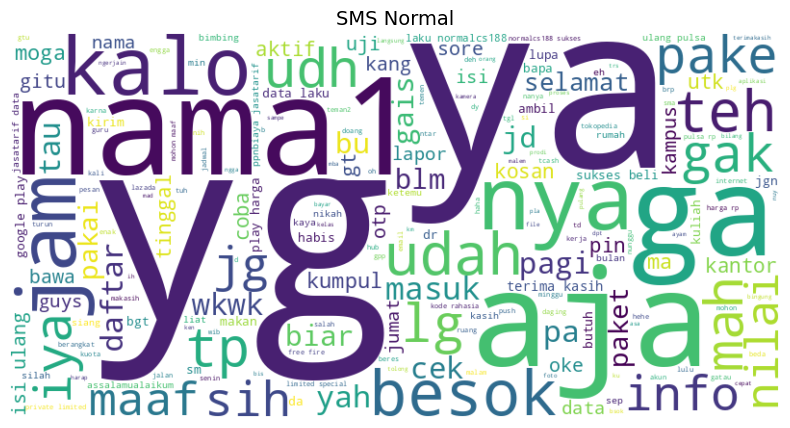

In [32]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Fungsi untuk menggabungkan teks
def combine_text(text_series):
    return ' '.join(text_series)

# Gabungkan teks hasil transformasi (teks normal)
normal_text_transformed = combine_text(df[df['label'] == 0]['teks'])

# Buat WordCloud untuk teks normal
wordcloud = WordCloud(
    width=800, height=400, background_color='white', colormap='viridis', max_words=200,  random_state=42).generate(normal_text_transformed)

# Tampilkan WordCloud teks normal
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('SMS Normal', fontsize=14)
plt.show()


# Dataset Splitting

In [33]:
X = df.teks
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1298,), (325,), (1298,), (325,))

# Pembuatan Model

In [34]:
# Definisikan parameter grid yang ingin diuji
svm_params = {
    'algo__C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000],
    'algo__gamma': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
}

# Buat pipeline
pipeline = Pipeline([
    ('prep', TfidfVectorizer(ngram_range=(1, 2))),
    ('algo', SVC(probability=True))
])

# Buat model GridSearchCV
model = GridSearchCV(pipeline, svm_params, cv=10, n_jobs=-1, verbose=1)

# Latih model
model.fit(X_train, y_train)

# Tampilkan hasil
print("Best Parameters:", model.best_params_)
print("Training Accuracy:", model.score(X_train, y_train))
print("Model Best Score:", model.best_score_)
print("Test Accuracy:", model.score(X_test, y_test))


Fitting 10 folds for each of 49 candidates, totalling 490 fits
Best Parameters: {'algo__C': 10, 'algo__gamma': 1}
Training Accuracy: 1.0
Model Best Score: 0.9491771019677996
Test Accuracy: 0.9692307692307692


# Evaluation

In [35]:
y_pred = model.predict(X_test)
label_mapping = {1: "SMS Spam", 0: "SMS Normal"}

for pred, sms in zip(y_pred[:20], X_test[:20]):
    print(f'PRED: {label_mapping[pred]} - SMS: {sms}\n')

PRED: SMS Spam - SMS: grab nikmat 75 diskon 10x guna masuk kode cobagrabcar ajak temantemanmu keliling bandung tanp

PRED: SMS Spam - SMS: info resmi tri care selamat nomor pilih hadiah 1 unit mobil dri tri care pin menang br25h99 info wwwgebeyar3caretk

PRED: SMS Normal - SMS: selamat siang reservasi bandros orang

PRED: SMS Normal - SMS: da sebenernya makan indomie ge mah

PRED: SMS Normal - SMS: format beranta odp google sheet sdg rapi besok subuh harap cek ya

PRED: SMS Normal - SMS: hmm sebenernya cuman eksekusi jquery control sep coba cek jquery yg dicotroller klik button controller yg nyetak pdf

PRED: SMS Normal - SMS: akademik perhati tuk jadwal kontrak kuliah ang 2012 sebenarny kuliah jadwal kur yg ang 2013 ato atas 201420152016 jadwal yg jadwal bayang tuk tuju kontrak kuliahhal atas ga laku tuk mk yg jalan ang spt skripsi sidangdemikian harap perhati

PRED: SMS Normal - SMS: isi ulang pulsa rp 20000 hasil sn03201600000017093146 07102023 214149beli paket internetnelpon termur

In [36]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
matrix = confusion_matrix(y_test, y_pred)

# Create DataFrame from the matrix
df_confusion = pd.DataFrame(matrix, index=['Actual Ham', 'Actual Spam'], columns=['Predicted Ham', 'Predicted Spam'])

# Display the DataFrame
print("Confusion Matrix:")
print(df_confusion)

true_negative, false_positive, false_negative, true_positive = matrix.ravel()

print("\nMetrics:")
print("=" * 20)
print(f'True Negative (TN): {true_negative}')
print(f'False Positive (FP): {false_positive}')
print(f'False Negative (FN): {false_negative}')
print(f'True Positive (TP): {true_positive}')


Confusion Matrix:
             Predicted Ham  Predicted Spam
Actual Ham             154               5
Actual Spam              5             161

Metrics:
True Negative (TN): 154
False Positive (FP): 5
False Negative (FN): 5
True Positive (TP): 161


In [37]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       159
           1       0.97      0.97      0.97       166

    accuracy                           0.97       325
   macro avg       0.97      0.97      0.97       325
weighted avg       0.97      0.97      0.97       325



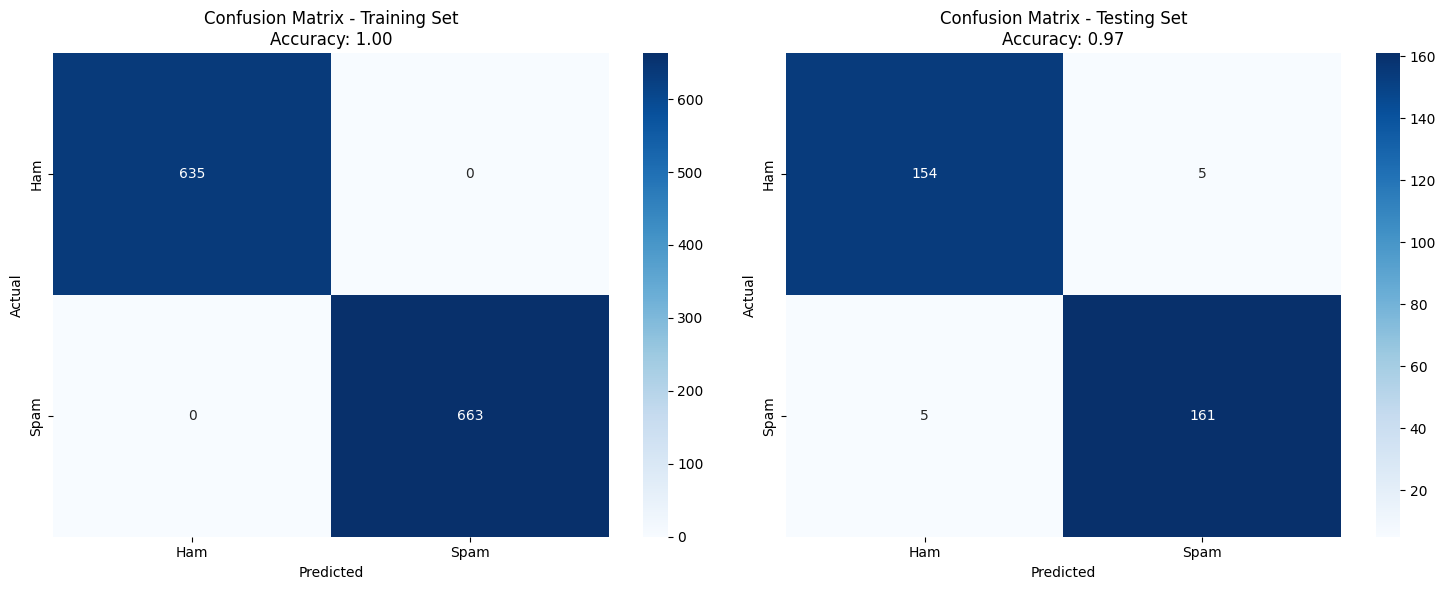

In [38]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

# Get predictions on both training and testing sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Calculate accuracy scores
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

# Create subplots for training and testing confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Create heatmap for training confusion matrix
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", ax=axes[0], xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title(f"Confusion Matrix - Training Set\nAccuracy: {accuracy_train:.2f}")

# Create heatmap for testing confusion matrix
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", ax=axes[1], xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
axes[1].set_title(f"Confusion Matrix - Testing Set\nAccuracy: {accuracy_test:.2f}")

plt.tight_layout()
plt.show()


# Deploy Sederhana

### Percobaan prediksi SMS Normal yang tidak ada dalam dataset

In [39]:
text1 = ["besok jemput aku di dekat bank bri sekalian mau ngambil uang"]
text2 = ["Selamat ulang tahun! Semoga hari Anda penuh kebahagiaan dan diberkati dengan banyak keberuntungan. Nikmati hari Anda!"]
text3 = ["Ingatkan saya untuk mengambil laundry Anda saat saya lewat di depan rumah Anda nanti sore. Terima kasih!"]

texts = [text1, text2, text3]

for text in texts:
    predicted_class = model.predict(text)
    if predicted_class[0] == 1:
        predicted_label = "SMS spam"
    else:
        predicted_label = "SMS Normal"

    predicted_proba = model.predict_proba(text)

    print("Input Text:", text[0])
    print("Predicted Class:", predicted_label)
    print("Predicted Probabilities:", predicted_proba[0])
    print("=" * 50)


Input Text: besok jemput aku di dekat bank bri sekalian mau ngambil uang
Predicted Class: SMS Normal
Predicted Probabilities: [0.49050609 0.50949391]
Input Text: Selamat ulang tahun! Semoga hari Anda penuh kebahagiaan dan diberkati dengan banyak keberuntungan. Nikmati hari Anda!
Predicted Class: SMS spam
Predicted Probabilities: [0.3773668 0.6226332]
Input Text: Ingatkan saya untuk mengambil laundry Anda saat saya lewat di depan rumah Anda nanti sore. Terima kasih!
Predicted Class: SMS Normal
Predicted Probabilities: [0.85746312 0.14253688]


### Percobaan prediksi SMS Spam yang tidak ada dalam dataset

In [40]:
text1 = ["Sayng belikan aq pulsa di nmr ini, 085215126428, nanti aq yg tlpn km, ini aq"]
text2 = ["Promo terbaru! Dapatkan diskon 50% untuk semua produk kami. Kunjungi toko kami sekarang!"]
text3 = ["Anda terpilih menjadi pemenang undian berhadiah! Anda mendapatkan mobil baru. Hubungi kami segera untuk pengambilan hadiah"]

texts = [text1, text2, text3]

for text in texts:
    predicted_class = model.predict(text)
    if predicted_class[0] == 1:
        predicted_label = "SMS spam"
    else:
        predicted_label = "SMS Normal"

    predicted_proba = model.predict_proba(text)

    print("Input Text:", text[0])
    print("Predicted Class:", predicted_label)
    print("Predicted Probabilities:", predicted_proba[0])
    print("=" * 50)


Input Text: Sayng belikan aq pulsa di nmr ini, 085215126428, nanti aq yg tlpn km, ini aq
Predicted Class: SMS spam
Predicted Probabilities: [0.08596122 0.91403878]
Input Text: Promo terbaru! Dapatkan diskon 50% untuk semua produk kami. Kunjungi toko kami sekarang!
Predicted Class: SMS spam
Predicted Probabilities: [6.65304825e-06 9.99993347e-01]
Input Text: Anda terpilih menjadi pemenang undian berhadiah! Anda mendapatkan mobil baru. Hubungi kami segera untuk pengambilan hadiah
Predicted Class: SMS spam
Predicted Probabilities: [3.76727541e-08 9.99999962e-01]


# Save Model

In [41]:
import pickle

# Simpan model ke dalam file 'sms_spam_model.pkl'
with open('model-sms_spam.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)